<a href="https://colab.research.google.com/github/robd123/AML/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import urllib.request
import os
datapath = os.path.join("datasets", "epi", "")
os.makedirs(datapath, exist_ok=True)
file_path = "https://raw.githubusercontent.com/robd123/AML/main/Project2/epi_r.csv"
urllib.request.urlretrieve(file_path, datapath + "epi_r.csv")

('datasets/epi/epi_r.csv', <http.client.HTTPMessage at 0x7f67dba3b750>)

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

food = pd.read_csv(datapath + "epi_r.csv", thousands=',')
food.sort_values(by=['calories'], ascending=False).head()


,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,alcoholic,almond,amaretto,anchovy,anise,anniversary,anthony bourdain,aperitif,appetizer,apple,apple juice,apricot,arizona,artichoke,arugula,asian pear,asparagus,aspen,atlanta,australia,avocado,back to school,backyard bbq,bacon,bake,banana,...,vegan,vegetable,vegetarian,venison,vermont,vermouth,vinegar,virginia,vodka,waffle,walnut,wasabi,washington,"washington, d.c.",watercress,watermelon,wedding,weelicious,west virginia,westwood,wheat/gluten-free,whiskey,white wine,whole wheat,wild rice,windsor,wine,winter,wisconsin,wok,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
11391,Pear-Cranberry Mincemeat Lattice Pie,4.375,30111218.0,200968.0,1722763.0,27675110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6368,Deep-Dish Wild Blueberry Pie,4.375,29997918.0,200210.0,1716279.0,27570999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19672,"Apricot, Cranberry and Walnut Pie",4.375,13062948.0,87188.0,747374.0,12005810.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2976,Lamb Köfte with Tarator Sauce,5.000,4518216.0,166471.0,44198.0,7540990.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9731,"Rice Pilaf with Lamb, Carrots, and Raisins",5.000,4157357.0,236489.0,221495.0,3134853.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Data Preprocessing**


*   Replace missing values with median values.
*   Use standard scaler.
*   Remove all foods with more than 10000 calories.  There are some extreme outliers that are physically impossible. I don't know how big a pie would need to be to have thirty million calories, so it's safe to assume the data is wrong.
*   Also remove food with less than 50 calories, most of these are recipes for preparing ingredients like stock or clarified butter.  Since we're trying to rate meals they can be safely removed.
*   A gram of fat has 9 calories and a gram of protein has 4 calories.  Remove any food that has fewer calories than nutritionally possible.
*   I'm assuming that sodium is measured in milligrams, so will be removing anything over 20000.  40 grams is roughly the lethal limit for sodium, so removing any recipe with over half the lethal amount seems safe.
*  Epicurious does not allow a zero rating, so any recipe that has a zero has not been rated.  This can be considered missing data, since its the value I'm trying to predict it doesn't make to give use the imputer to fill it in.

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

food_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

food = food[food.calories < 10000]  # Remove impossible foods
food = food[food.calories > 50]  # Remove ingredients
food = food[food.sodium < 20000]  # Remove lethal foods
food = food[food.calories >= (4 * food.protein + 9 * food.fat)]  # Remove foods that don't make sense calorically
food = food[food.rating > 0]  # Remove unrated recipes

food = food.drop_duplicates(keep='first')

food_data = food[['rating', 'calories', 'protein', 'fat', 'sodium']]

food_tr = food_pipeline.fit_transform(food_data)
food_scaled = pd.DataFrame(food_tr, columns=['rating', 'calories', 'protein', 'fat', 'sodium'])


In [62]:
food.sort_values(by=['rating'], ascending=True).head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,alcoholic,almond,amaretto,anchovy,anise,anniversary,anthony bourdain,aperitif,appetizer,apple,apple juice,apricot,arizona,artichoke,arugula,asian pear,asparagus,aspen,atlanta,australia,avocado,back to school,backyard bbq,bacon,bake,banana,...,vegan,vegetable,vegetarian,venison,vermont,vermouth,vinegar,virginia,vodka,waffle,walnut,wasabi,washington,"washington, d.c.",watercress,watermelon,wedding,weelicious,west virginia,westwood,wheat/gluten-free,whiskey,white wine,whole wheat,wild rice,windsor,wine,winter,wisconsin,wok,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
10478,"Fettuccine with Pork, Greens, and Beans",1.25,754.0,40.0,39.0,1106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5518,Nachos,1.25,727.0,32.0,46.0,971.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17448,Soba With Green Chile Pesto,1.25,142.0,7.0,2.0,571.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8358,Spicy Garlic Pickles,1.25,156.0,4.0,1.0,2873.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18888,Blood-Orange Rum Punch,1.25,324.0,1.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
food_data.describe()

,rating,calories,protein,fat,sodium
count,12809.000000,12809.000000,12809.000000,12809.000000,12809.000000
mean,4.092777,526.375439,23.212897,30.291358,631.682489
std,0.645741,599.302056,38.624906,43.663551,1114.456602
min,1.250000,51.000000,0.000000,0.000000,0.000000
25%,3.750000,228.000000,4.000000,10.000000,114.000000
50%,4.375000,375.000000,10.000000,19.000000,337.000000
75%,4.375000,626.000000,31.000000,36.000000,768.000000
max,5.000000,9831.000000,1114.000000,923.000000,19986.000000


In [64]:
food_scaled.describe()

,rating,calories,protein,fat,sodium
count,1.280900e+04,1.280900e+04,1.280900e+04,1.280900e+04,1.280900e+04
mean,-8.073711e-16,-3.743937e-17,1.833008e-16,-4.989893e-17,1.795911e-17
std,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00
min,-4.402519e+00,-7.932461e-01,-6.010061e-01,-6.937718e-01,-5.668297e-01
25%,-5.308473e-01,-4.978910e-01,-4.974419e-01,-4.647389e-01,-4.645337e-01
50%,4.370706e-01,-2.525961e-01,-3.420957e-01,-2.586093e-01,-2.644284e-01
75%,4.370706e-01,1.662408e-01,2.016162e-01,1.307467e-01,1.223222e-01
max,1.404989e+00,1.552637e+01,2.824161e+01,2.044597e+01,1.736727e+01


In [65]:
food_scaled.corr()['rating'].sort_values(ascending=False)

rating      1.000000
calories    0.047292
fat         0.045923
sodium      0.040126
protein     0.039482
Name: rating, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67d87fcd50>,
      dtype=object)

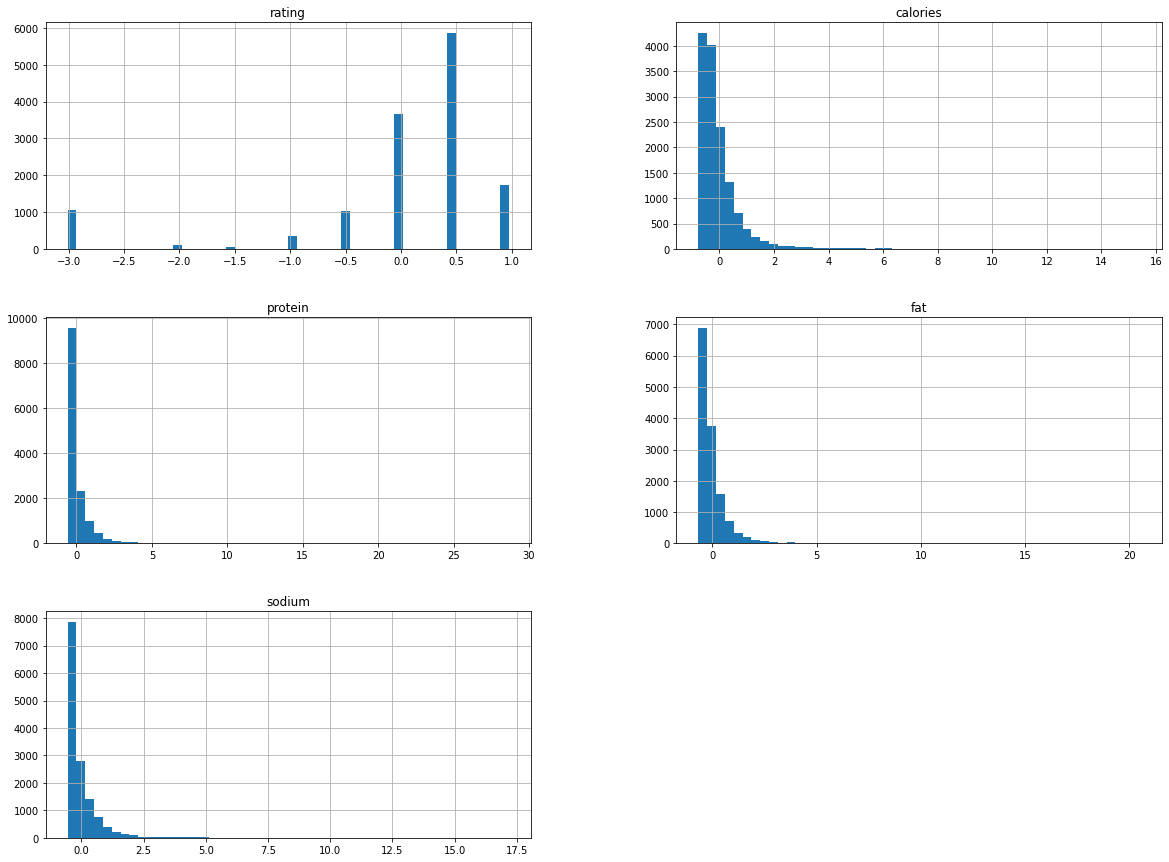

In [54]:
food_scaled.hist(bins=50, figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67d8285590>,
      dtype=object)

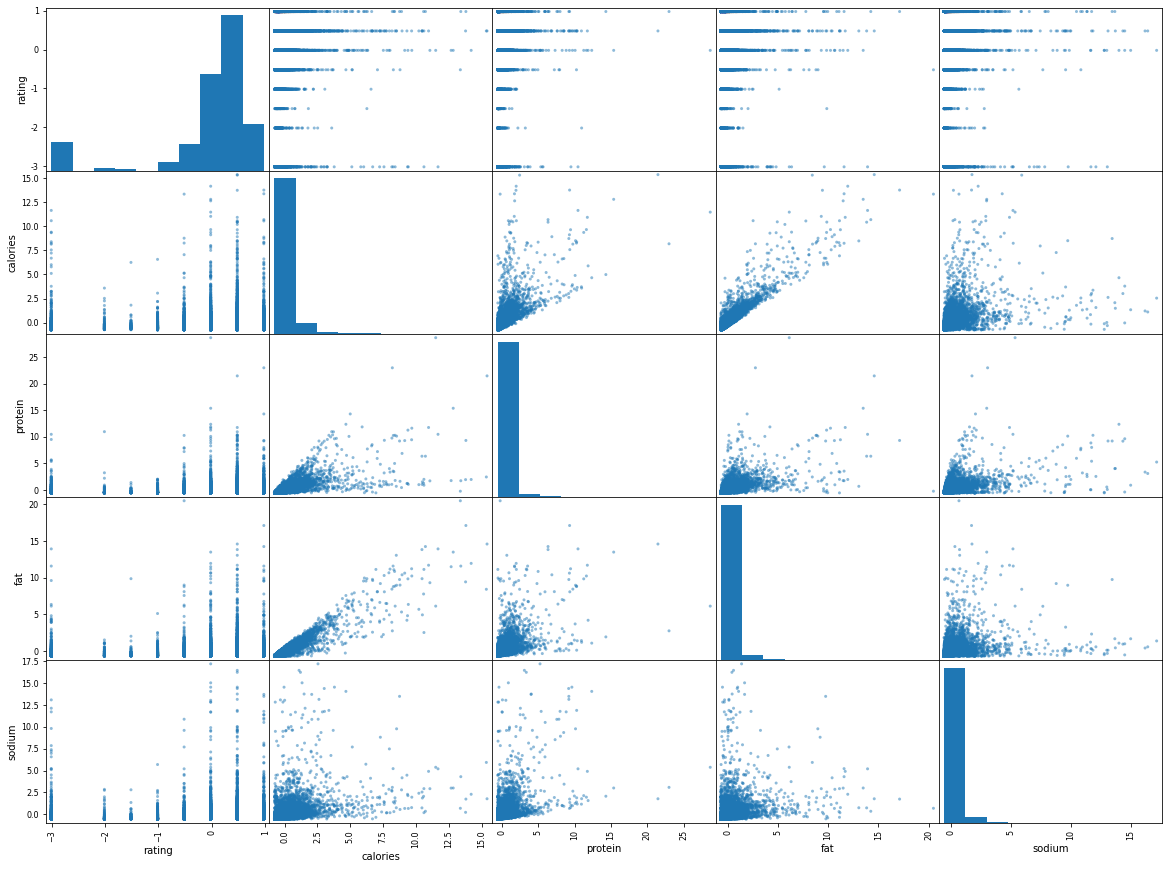

In [55]:
from pandas.plotting import scatter_matrix

attributes = ['rating', 'calories', 'protein', 'fat', 'sodium']
scatter_matrix(food_scaled[attributes], figsize=(20,15))
